# Reconstructing DICOM Data

In [1]:
import os
import numpy as np
from pytomography.io.SPECT import dicom
from pytomography.transforms import SPECTAttenuationTransform, SPECTPSFTransform
from pytomography.algorithms import OSEM
from pytomography.projections import SPECTSystemMatrix
from pytomography.utils import print_collimator_parameters
import matplotlib.pyplot as plt
import pydicom

## Part 1: Opening Data

First we specify the required filepaths to open the SPECT scan (`file_NM`) and the CT data files (`files_CT`).

In [2]:
# initialize the `path`` variable below to specify the location of the required data
path = '/disk1/pytomography_tutorial_data/dicom_tutorial/' 
path_CT = os.path.join(path, 'CT_files')
files_CT = [os.path.join(path_CT, file) for file in os.listdir(path_CT)]
file_NM = os.path.join(path, 'projection_data.dcm')

The metadata for object space and image space can be obtained from the projection data file using `dicom.get_metadata`

In [3]:
object_meta, image_meta = dicom.get_metadata(file_NM, index_peak=3)

The photopeak can be obtained using the `dicom.get_projections` function. Note that most raw SPECT DICOM files contain data from multiple energy windows. If the `index_peak` argument isn't included, then projections the third argument it returns would contain all energy windows (along the batch dimension). In this case, we specify `index_peak=3`, so it only returns the projections corresponding to that energy window. This infomation can be obtained by opening the dicom file using pydicom and looking at the `EnergyWindowInformationSequence` attribute

In [4]:
photopeak = dicom.get_projections(file_NM, index_peak=3)
photopeak.shape

Returned projections have dimensions (1 Ltheta Lr Lz)


torch.Size([1, 180, 128, 128])

The shape of the photopeak is $(1, N_{angles}, \text{Width}, \text{Height})$. The extra channel dimension at the beginning is such that data is compatible with potential AI models

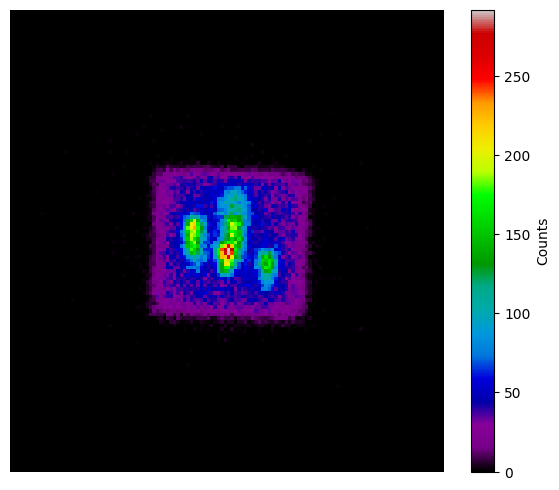

In [5]:
plt.figure(figsize=(7,6))
plt.pcolormesh(photopeak[0,0].cpu().T, cmap='nipy_spectral')
plt.axis('off')
plt.colorbar(label='Counts')

Scatter projections can be estimated using the triple energy window function `dicom_get_scatterTEW`. One needs to specify the index of the peak, and lower/upper energy windows

In [6]:
scatter = dicom.get_scatter_from_TEW(file_NM, index_peak=3, index_lower=2, index_upper=4)

## Part 2: Modeling

### Attenuation Transform

The attenuation transform is used to "correct" for the fact that some photons get atteunated in the patient before they reach the detector. PyTomography has functionality to do attenuation correction provided either (i) an argument `attenuation_map=...` OR (ii) an argument `filepath=...` is provided to the `SPECTAttenuationTransform`.

* `attenuation_map` must be aligned with the SPECT projection data and have units of cm $^{-1}$ .
* `filepath` specifies the directory of some CT scan which will be used for attenuation correction. PyTomography has functionality to align this with the SPECT projections and convert to units of cm $^{-1}$.

In this case, since we're reconstructing DICOM data, it's easier to use `filepath` than to manually align/rescale the CT data

In [7]:
att_transform = SPECTAttenuationTransform(filepath=files_CT)

If we want to view the attenuation map, we need to *configure* the `att_transform` so that (i) the CT data can be aligned with SPECT projection data and (ii) the CT data can be converted to attenuation coefficients.

* *Note*: This is not required if you don't want to view the attenuation map. Later, when the system matrix is built, it automatically configures all the transforms

In [8]:
att_transform.configure(object_meta, image_meta)
attenuation_map = att_transform.attenuation_map

Cortical Bone Peak: 1419.3499755859375 HU
Effective CT Energy Determined: 75.89505539164563 keV


Viewing the attenuation map allows for a consistency check to ensure that it's properly aligned with the projection data

In [9]:
sample_slice = attenuation_map.cpu()[0][:,70].T

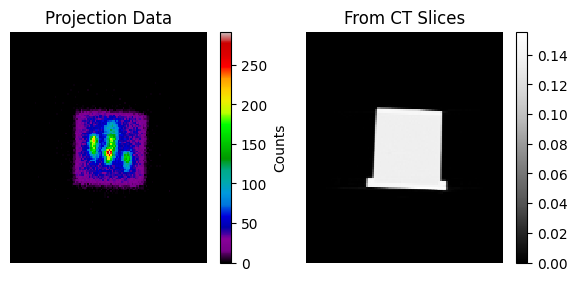

In [10]:
plt.subplots(1,2,figsize=(7,3))
plt.subplot(121)
plt.title('Projection Data')
plt.pcolormesh(photopeak[0,0].cpu().T, cmap='nipy_spectral')
plt.axis('off')
plt.colorbar(label='Counts')
plt.subplot(122)
plt.title('From CT Slices')
plt.pcolormesh(sample_slice, cmap='Greys_r')
plt.axis('off')
plt.colorbar()

### PSF Modeling

PSF modeling requires knowing the parameters of the collimators used for the scan. A list of all supported collimator types can be determined by uncommenting the following line and running it

In [11]:
#print_collimator_parameters()

In our case, we know that this scan was performed on a Siemens Symbia scanner with medium energy collimators.

In [12]:
collimator_name = 'SY-ME'
energy_kev = 208
psf_meta = dicom.get_psfmeta_from_scanner_params(collimator_name, energy_kev)
print(psf_meta)

Now we can build our PSF transform required to create the system matrix

In [13]:
psf_transform = SPECTPSFTransform(psf_meta)

## System Matrix

Now that we have the required transforms, we can begin to build the system matrix. It requires:
1. `obj2obj_transforms`. These map from object space to object space. In the case of SPECT imaging, both the attenuation transform and PSF transform correspond to these types of transforms.
2. `im2im_transforms`: These map from image space to image space. Though we have none here, they would be used to model PSF in PET imaging.
3. `object_meta` and `image_meta`. These are used to initialize the transforms. For example, data from `object_meta` is used to align the attenuation map, and radial position from `image_meta` is used to get proper blurring parameters for the PSF transform

In [14]:
system_matrix = SPECTSystemMatrix(
        obj2obj_transforms = [att_transform,psf_transform],
        im2im_transforms = [],
        object_meta = object_meta,
        image_meta = image_meta)

Cortical Bone Peak: 1419.3499755859375 HU
Effective CT Energy Determined: 75.89505539164563 keV


The system matrix $H$ represents the imaging system and maps an object $f$ to a corresponding image $g$ under the imaging system

# Reconstruct the object

We'll reconstruct the object using OSEM. For this, we need to specify the measured image data (`photopeak`/`scatter`) and the `system_matrix`

In [15]:
reconstruction_algorithm = OSEM(
    image = photopeak,
    system_matrix = system_matrix,
    scatter=scatter)

We can reconstruct the object by calling the reconstruction algorithm for a given number of iterations/subsets.

In [16]:
reconstructed_object = reconstruction_algorithm(n_iters=4, n_subsets=10)

We can also get a string corresponding to the type of reconstruction done. This is useful when exporting to DICOM

In [17]:
recon_name = reconstruction_algorithm.recon_name
recon_name

'OSEM_4it10ss'

We can compare this reconstruction to one done by the vendor:

In [18]:
ds_recon = pydicom.read_file(os.path.join(path, 'scanner_recon.dcm'))
recon_vendor = ds_recon.pixel_array / 90
recon_vendor = np.transpose(recon_vendor, (2,1,0))

We can looks at axial slices from all three reconstructions.

In [19]:
slice_pytomography = reconstructed_object.cpu()[0][:,:,70].T
slice_vendor = recon_vendor[:,:,70].T

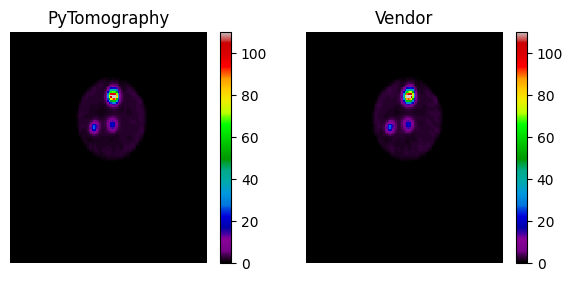

In [20]:
plt.subplots(1,2,figsize=(7,3))
plt.subplot(121)
plt.title('PyTomography')
plt.pcolormesh(slice_pytomography , cmap='nipy_spectral', vmax=110)
plt.axis('off')
plt.colorbar()
plt.subplot(122)
plt.title('Vendor')
plt.pcolormesh(slice_vendor, cmap='nipy_spectral', vmax=110)
plt.axis('off')
plt.colorbar()
plt.show()

## Saving Data

PyTomography has functionality for saving DICOM data. There are a few things required:

1. The folder where you want to save the data. The folder can't exist already (has to be a new folder); this prevents overwriting potential data.
2. The reconstructed object itself: in this case, `recon_CTslices`
3. The filepath of the projection data `file_NM`. Much of the study/patient information is copied over from this file to the reconstructed file.
4. An optional string that represents the type of reconstruction performed. If left blank, will be an empty string `''`

In [21]:
# Modify the path below to a location on your computer where you want to save the data
save_path = '/disk1/pytomography_tutorial_data/dicom_tutorial/output'
dicom.save_dcm(save_path, reconstructed_object, file_NM, recon_name)

The data can now be exported to any DICOM viewer of your choice!